In [97]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import math
import gc

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
%config IPCompleter.greedy=True
%autosave 30

Autosaving every 30 seconds


In [3]:
train=pd.read_csv("Train.csv")
test=pd.read_csv("Test.csv")
locinfo=pd.read_csv("airqo_metadata.csv")

## Location data processing

In [4]:
locdata = locinfo.copy()
locdata=locinfo.iloc[:,1:]
locdata.fillna(5000,inplace=True)
locdata.drop(['dist_motorway','dist_unclassified','loc_altitude'],axis=1,inplace=True)
locdata['popn_den']=locdata['popn']/(locdata['km2']*1000)
locdata['hh_den']=locdata['hh']/(locdata['km2']*1000)
locdata['firewood_den']=locdata['hh_cook_firewood']/(locdata['hh'])
locdata['waste_den']=locdata['hh_burn_waste']/(locdata['hh'])
locdata['charcoal_den']=locdata['hh_cook_charcoal']/(locdata['hh'])

locdata.set_index(['location'],inplace=True)
locdata.head()

,km2,aspect,dist_trunk,dist_primary,dist_secondary,dist_tertiary,dist_residential,popn,hh,hh_cook_charcoal,hh_cook_firewood,hh_burn_waste,popn_den,hh_den,firewood_den,waste_den,charcoal_den
location,,,,,,,,,,,,,,,,,
A,1.9,194.0,5000.000000,14.695789,343.595039,575.917422,254.307415,4763,809,508,43,142,2.506842,0.425789,0.053152,0.175525,0.627936
B,5.4,219.8,528.078476,2172.680462,1144.376412,531.103271,1.042809,22243,5735,116,1144,239,4.119074,1.062037,0.199477,0.041674,0.020227
C,8.5,168.7,32.885520,4794.704552,12.730489,72.459340,13.931350,97895,26873,21316,751,9835,11.517059,3.161529,0.027946,0.365981,0.793213
D,0.8,90.0,5000.000000,265.896472,5000.000000,339.693908,11.601442,3596,663,7,651,99,4.495000,0.828750,0.981900,0.149321,0.010558
E,1.6,121.0,850.423131,5000.000000,1738.872942,137.722087,3.836589,6064,1297,985,26,43,3.790000,0.810625,0.020046,0.033153,0.759445


# Observations


<p>Pollution is highly dependent on the following:
    <li> 1. population density </li>
    <li> 2. burn of waste </li>
    <li> 3. Area </li> </p>

# Features engineering

In [5]:
# covert features  fron string to List of values 
def replace_nan(x):
    if x=="":
        return np.nan
    else :
        return float(x)
features=["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]
for feature in features : 
    train[feature]=train[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan","").split(",")])
    test[feature]=test[feature].apply(lambda x: [ replace_nan(X)  for X in x.replace("nan","").split(",")]) 

In [6]:
def aggregate_features(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["std_"+col_name]=x[col_name].apply(np.std)
    x["var_"+col_name]=x[col_name].apply(np.var)
    x["median_"+col_name]=x[col_name].apply(np.median)
    x["ptp_"+col_name]=x[col_name].apply(np.ptp)
    return x  
def remove_nan_values(x):
    return [e for e in x if not math.isnan(e)]


In [7]:
for col_name in tqdm(features):
    train[col_name]=train[col_name].apply(remove_nan_values)
    test[col_name]=test[col_name].apply(remove_nan_values)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.64it/s]


In [8]:
for col_name in tqdm(features):
    train=aggregate_features(train,col_name)
    test=aggregate_features(test,col_name)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:27<00:00,  4.58s/it]


In [9]:
train.drop(features,1,inplace=True)
test.drop(features,1,inplace=True)

In [10]:
train.head()

,ID,location,target,max_temp,min_temp,mean_temp,std_temp,var_temp,median_temp,ptp_temp,...,var_wind_spd,median_wind_spd,ptp_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press,ptp_atmos_press
0,ID_train_0,C,45.126304,27.208333,19.275000,22.299527,2.594011,6.728895,21.358333,7.933333,...,0.155268,0.666250,1.355000,87.871667,87.614167,87.752434,0.070374,0.004952,87.762083,0.257500
1,ID_train_1,D,79.131702,33.616667,17.983333,24.679063,4.266955,18.206903,23.791667,15.633333,...,0.290736,0.744167,2.760833,90.725000,90.056667,90.429924,0.156000,0.024336,90.429167,0.668333
2,ID_train_10,A,32.661304,31.841667,18.458333,24.112317,3.776377,14.261020,23.304167,13.383333,...,0.342484,0.942500,2.420000,88.813333,87.982500,88.420931,0.179481,0.032213,88.425000,0.830833
3,ID_train_100,A,53.850238,27.491667,16.941667,20.845273,3.080140,9.487259,19.541667,10.550000,...,0.336701,1.388333,2.469167,88.685000,87.965000,88.376915,0.161758,0.026166,88.400000,0.720000
4,ID_train_1000,A,177.418750,28.750000,17.525000,21.870732,3.286870,10.803515,20.950000,11.225000,...,0.181690,0.542917,1.796667,88.719167,88.268333,88.538104,0.118369,0.014011,88.552500,0.450833


In [11]:
test.head()

,ID,location,max_temp,min_temp,mean_temp,std_temp,var_temp,median_temp,ptp_temp,max_precip,...,var_wind_spd,median_wind_spd,ptp_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press,ptp_atmos_press
0,ID_test_0,C,26.858333,17.050000,21.389532,2.731833,7.462909,20.908333,9.808333,5.728,...,0.154279,0.767500,1.744167,88.020833,87.474167,87.748506,0.132764,0.017626,87.752500,0.546667
1,ID_test_1,C,26.991667,17.275000,21.302824,2.289268,5.240748,20.716667,9.716667,15.831,...,0.208605,0.771667,1.889167,88.181667,87.572500,87.936963,0.113756,0.012940,87.928333,0.609167
2,ID_test_10,D,29.850000,17.108333,22.144421,2.943047,8.661528,21.458333,12.741667,1.327,...,0.324600,0.567500,2.890000,90.785000,90.115000,90.521357,0.136316,0.018582,90.536667,0.670000
3,ID_test_100,C,27.325000,18.633333,22.361639,2.480003,6.150415,21.616667,8.691667,3.604,...,0.185370,0.685000,1.575000,88.078333,87.560000,87.754848,0.125583,0.015771,87.726667,0.518333
4,ID_test_1000,D,31.091667,16.908333,23.560243,4.136978,17.114585,22.825000,14.183333,0.000,...,0.193861,0.609091,1.761667,90.798333,90.105833,90.475030,0.161193,0.025983,90.487273,0.692500


### Observations
<p> Particle matters will increase if
    <li>- temperature is moderate [20-24C]</li>
    <li>- precipitation is low</li>
    <li>- humidity is high</li>
    <li>- wind direction increases </li>
    <li>- wind speed decreases</li>
</p>

### Scaling of dataset

In [12]:
scaler = MinMaxScaler()
col=train.columns
train_scale_col=col[3:]
train_scale=train.iloc[:,3:].copy()
train_scale=scaler.fit_transform(train_scale)
train_scale=pd.DataFrame(train_scale)
train_scale.columns=train_scale_col
train_lead=train.iloc[:,[0,1,2]].copy()
train=pd.concat([train_lead,train_scale],1)

skewcols=['max_precip', 'mean_precip', 'std_precip', 'var_precip',
          'max_rel_humidity','max_wind_dir', 'min_wind_dir',
          'max_wind_spd', 'min_wind_spd', 'mean_wind_spd', 'std_wind_spd', 'var_wind_spd', 'median_wind_spd', 'ptp_wind_spd',
          'max_atmos_press', 'min_atmos_press', 'mean_atmos_press']
for col in skewcols:
    # Log transforming the variable
    train[col] = np.log1p(train[col])
    
train.head()

,ID,location,target,max_temp,min_temp,mean_temp,std_temp,var_temp,median_temp,ptp_temp,...,var_wind_spd,median_wind_spd,ptp_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press,ptp_atmos_press
0,ID_train_0,C,45.126304,0.444940,0.805623,0.413890,0.396029,0.199237,0.348454,0.345238,...,0.020512,0.050962,0.034425,0.000000,0.106103,0.044941,0.006243,0.002570,0.051113,0.000000
1,ID_train_1,D,79.131702,0.826389,0.616137,0.679545,0.720912,0.555377,0.649485,0.803571,...,0.040230,0.065047,0.089143,0.628864,0.622030,0.632371,0.433140,0.287789,0.879400,0.529538
2,ID_train_10,A,32.661304,0.720734,0.685819,0.616273,0.625642,0.432944,0.589175,0.669643,...,0.047661,0.100030,0.076149,0.253811,0.203066,0.226911,0.550207,0.403702,0.256988,0.738990
3,ID_train_100,A,53.850238,0.461806,0.463325,0.251534,0.490434,0.284824,0.123711,0.500992,...,0.046833,0.174468,0.078034,0.222786,0.198666,0.215896,0.461848,0.314712,0.249224,0.596133
4,ID_train_1000,A,177.418750,0.536706,0.548900,0.366018,0.530581,0.325665,0.297938,0.541171,...,0.024388,0.028253,0.051940,0.231140,0.272324,0.255656,0.245528,0.135866,0.296584,0.249194


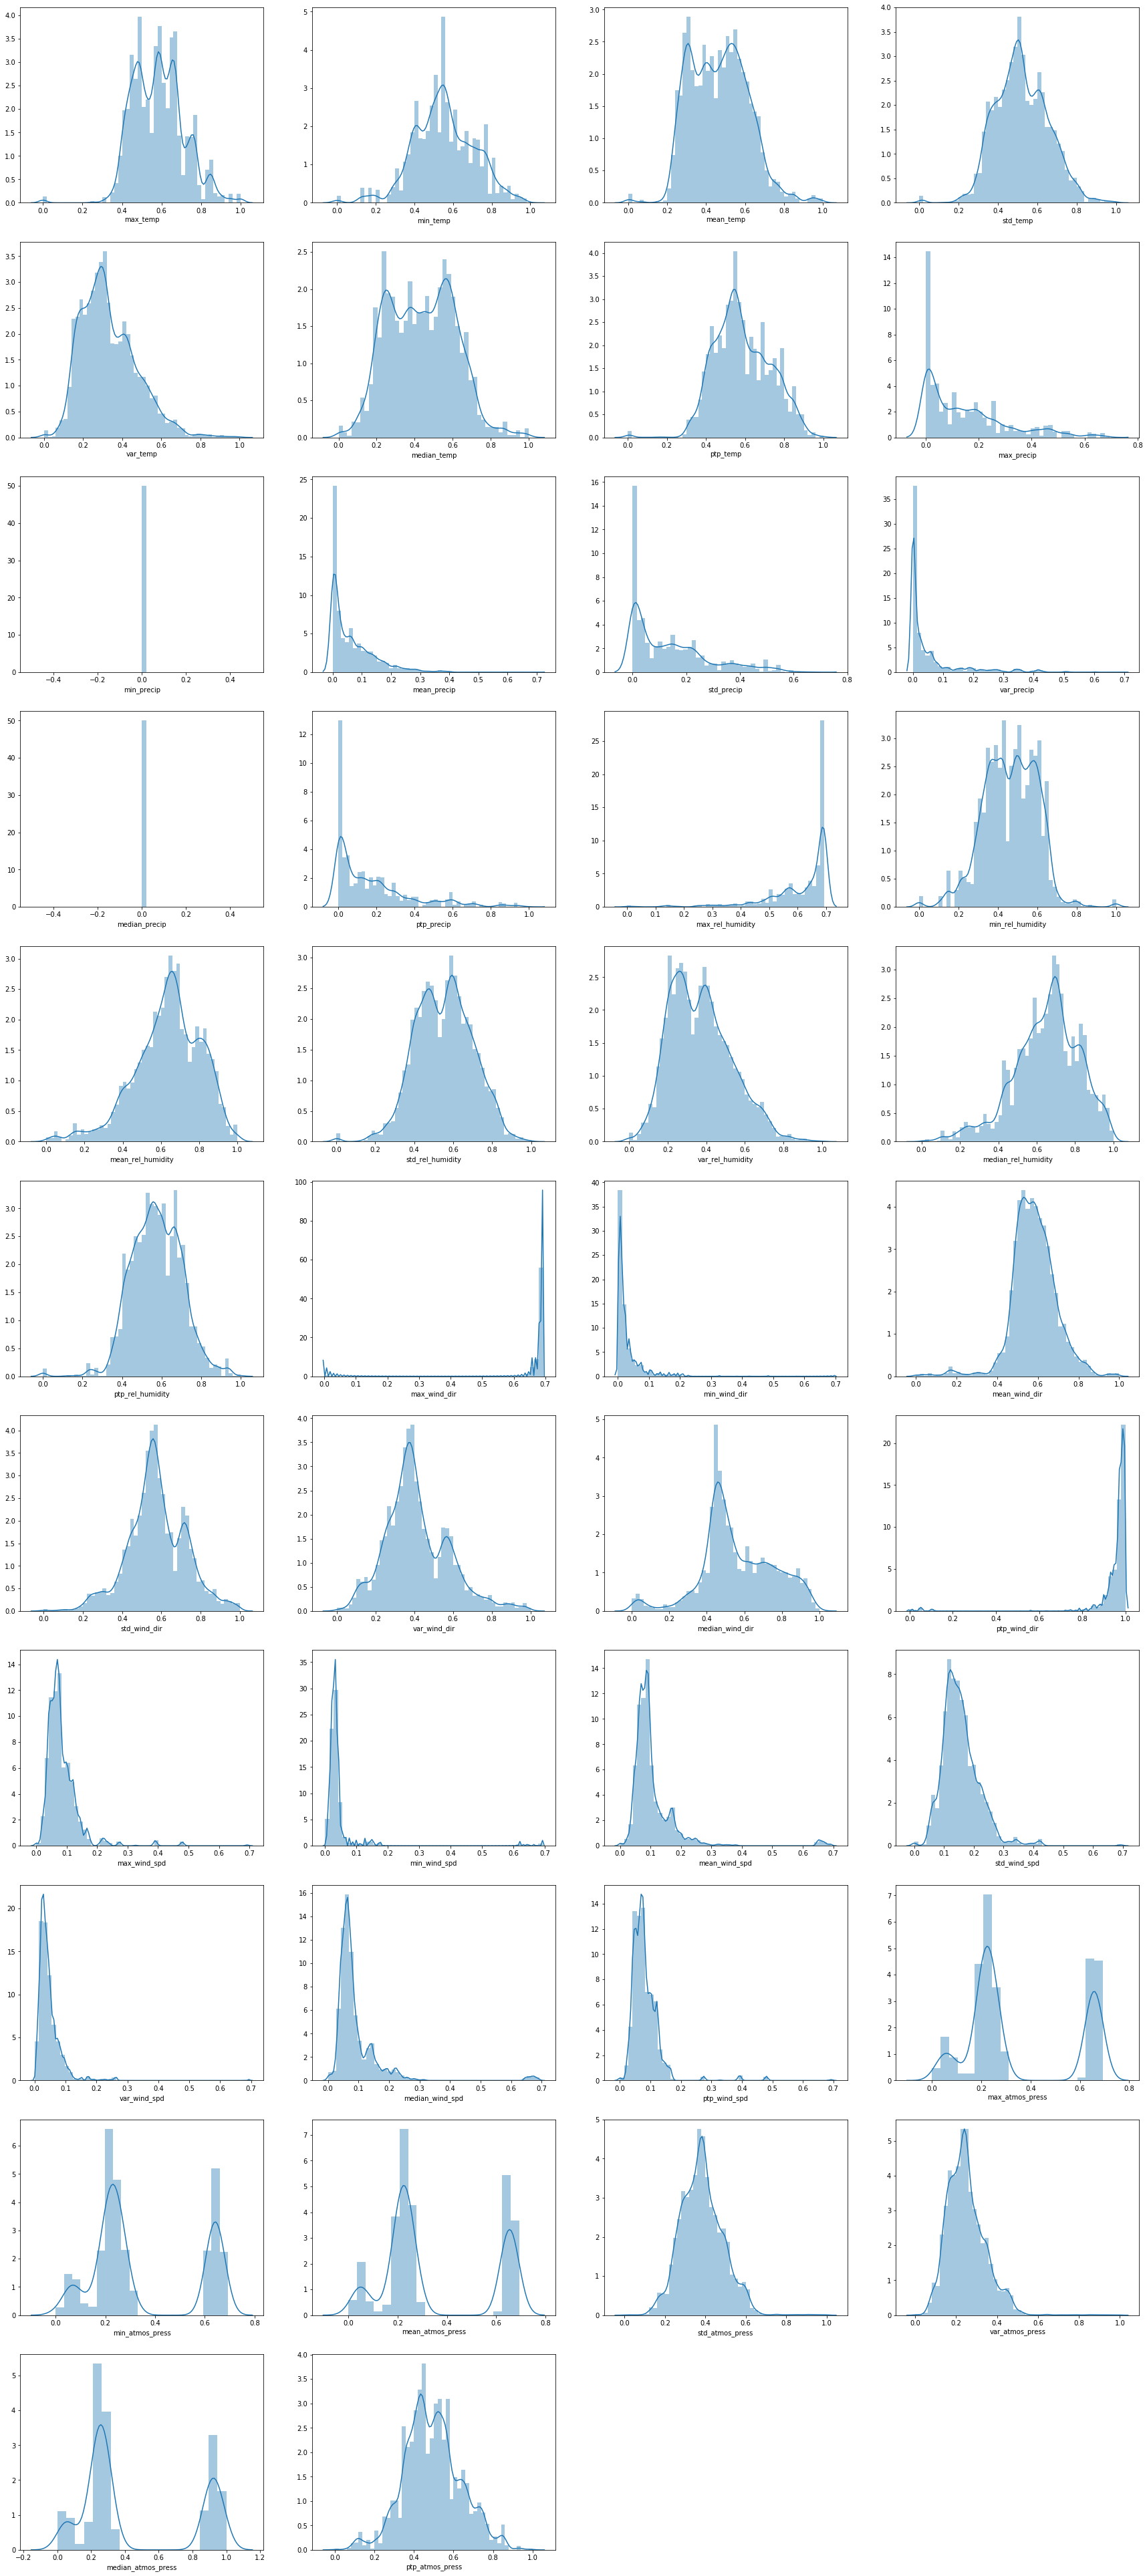

In [98]:
plt.figure(figsize=(30, 70))
i = 0
for col in train.columns[3:]:
    plt.subplot(11,4,i+1)
    sns.distplot(train[col])
    plt.xlabel(col)
    i = i + 1

plt.show()

In [13]:
col=test.columns
test_scale_col=col[2:]
#print(test_scale_col)
test_scale=test.iloc[:,2:].copy()
test_scale=scaler.transform(test_scale)
test_scale=pd.DataFrame(test_scale)
test_scale.columns=test_scale_col
test_lead=test.iloc[:,[0,1]].copy()
test=pd.concat([test_lead,test_scale],1)
for col in skewcols:
    # Log transforming the variable
    test[col] = np.log1p(test[col])
test.head()

,ID,location,max_temp,min_temp,mean_temp,std_temp,var_temp,median_temp,ptp_temp,max_precip,...,var_wind_spd,median_wind_spd,ptp_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press,ptp_atmos_press
0,ID_test_0,C,0.424107,0.479218,0.312296,0.422794,0.222012,0.292784,0.456845,0.117761,...,0.020366,0.069227,0.049874,0.044752,0.066634,0.043768,0.317296,0.189060,0.048137,0.372718
1,ID_test_1,C,0.432044,0.512225,0.302616,0.336849,0.153063,0.269072,0.451389,0.296696,...,0.028322,0.069972,0.055570,0.090861,0.094518,0.098568,0.222529,0.120109,0.102743,0.453276
2,ID_test_10,D,0.602183,0.487775,0.396574,0.463811,0.259203,0.360825,0.631448,0.028542,...,0.045099,0.032821,0.094023,0.638632,0.631610,0.647428,0.335006,0.203125,0.912785,0.531686
3,ID_test_100,C,0.451885,0.711491,0.420824,0.373889,0.181288,0.380412,0.390377,0.075695,...,0.024927,0.054370,0.043188,0.061482,0.091016,0.045662,0.281493,0.161761,0.040114,0.336198
4,ID_test_1000,D,0.676091,0.458435,0.554638,0.695670,0.521485,0.529897,0.717262,0.000000,...,0.026169,0.040501,0.050563,0.640790,0.630110,0.639827,0.459030,0.312026,0.897445,0.560687


# L1 models

## Segreagating datasets for each location

In [14]:
from sklearn.model_selection import train_test_split
trainL1, trainL2 = train_test_split(train.copy(),test_size=0.30,random_state=100)
print(trainL1.shape)
print(trainL2.shape)

(10877, 45)
(4662, 45)


In [15]:
Data_A=trainL1.loc[trainL1['location']=='A'].iloc[:,2:].copy()
Data_B=trainL1.loc[trainL1['location']=='B'].iloc[:,2:].copy()
Data_C=trainL1.loc[trainL1['location']=='C'].iloc[:,2:].copy()
Data_D=trainL1.loc[trainL1['location']=='D'].iloc[:,2:].copy()
Data_E=trainL1.loc[trainL1['location']=='E'].iloc[:,2:].copy()

In [16]:
print("A:",Data_A.shape)
print("B:",Data_B.shape)
print("C:",Data_C.shape)
print("D:",Data_D.shape)
print("E:",Data_E.shape)

A: (3620, 43)
B: (521, 43)
C: (1218, 43)
D: (3475, 43)
E: (2043, 43)


# Modelling

### Basic modelling for each loc

In [17]:
X = Data_A.iloc[:,1:].copy()
y = Data_A['target'].copy()
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X, y, test_size=0.15)

X = Data_B.iloc[:,1:].copy()
y = Data_B['target'].copy()
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X, y, test_size=0.15)

X = Data_C.iloc[:,1:].copy()
y = Data_C['target'].copy()
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X, y, test_size=0.15)

X = Data_D.iloc[:,1:].copy()
y = Data_D['target'].copy()
X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(X, y, test_size=0.15)

X = Data_E.iloc[:,1:].copy()
y = Data_E['target'].copy()
X_train_E, X_test_E, y_train_E, y_test_E = train_test_split(X, y, test_size=0.15)

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score,r2_score,mean_squared_error
rfc_B_A = RandomForestRegressor()
rfc_B_B = RandomForestRegressor()
rfc_B_C = RandomForestRegressor()
rfc_B_D = RandomForestRegressor()
rfc_B_E = RandomForestRegressor()


rfc_B_A.fit(X_train_A,y_train_A)
predictions = rfc_B_A.predict(X_test_A)
errA=sqrt(mean_squared_error(y_test_A, predictions))
print("Error - A:",sqrt(mean_squared_error(y_test_A, predictions)))

rfc_B_B.fit(X_train_B,y_train_B)
predictions = rfc_B_B.predict(X_test_B)
errB=sqrt(mean_squared_error(y_test_B, predictions))
print("Error - B:",sqrt(mean_squared_error(y_test_B, predictions)))

rfc_B_C.fit(X_train_C,y_train_C)
predictions = rfc_B_C.predict(X_test_C)
errC=sqrt(mean_squared_error(y_test_C, predictions))
print("Error - C:",sqrt(mean_squared_error(y_test_C, predictions)))

rfc_B_D.fit(X_train_D,y_train_D)
predictions = rfc_B_D.predict(X_test_D)
errD=sqrt(mean_squared_error(y_test_D, predictions))
print("Error - D:",sqrt(mean_squared_error(y_test_D, predictions)))

rfc_B_E.fit(X_train_E,y_train_E)
predictions = rfc_B_E.predict(X_test_E)
errE=sqrt(mean_squared_error(y_test_E, predictions))
print("Error - E:",sqrt(mean_squared_error(y_test_E, predictions)))

print ("Average error:",((errA+errB+errC+errD+errE)/5))

C:\Users\soumi\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Error - A: 35.12334538716901
Error - B: 11.868666259356118
Error - C: 48.40253444561102
Error - D: 18.986834494059075
Error - E: 13.41367455526116
Average error: 25.55901102829128


In [19]:
from sklearn.linear_model import Lasso
lm = Lasso(alpha=0.01)

lm.fit(X_train_A,y_train_A)
predictions = lm.predict(X_test_A)
errA=sqrt(mean_squared_error(y_test_A, predictions))
print("Error - A:",sqrt(mean_squared_error(y_test_A, predictions)))

lm.fit(X_train_B,y_train_B)
predictions = lm.predict(X_test_B)
errB=sqrt(mean_squared_error(y_test_B, predictions))
print("Error - B:",sqrt(mean_squared_error(y_test_B, predictions)))

lm.fit(X_train_C,y_train_C)
predictions = lm.predict(X_test_C)
errC=sqrt(mean_squared_error(y_test_C, predictions))
print("Error - C:",sqrt(mean_squared_error(y_test_C, predictions)))

lm.fit(X_train_D,y_train_D)
predictions = lm.predict(X_test_D)
errD=sqrt(mean_squared_error(y_test_D, predictions))
print("Error - D:",sqrt(mean_squared_error(y_test_D, predictions)))

lm.fit(X_train_E,y_train_E)
predictions = lm.predict(X_test_E)
errE=sqrt(mean_squared_error(y_test_E, predictions))
print("Error - E:",sqrt(mean_squared_error(y_test_E, predictions)))

print ("Average error:",((errA+errB+errC+errD+errE)/5))

Error - A: 38.055594092782215
Error - B: 18.85830642253272
Error - C: 67.22857493460802
Error - D: 25.487601556389507
Error - E: 19.00804894387383
Average error: 33.72762519003726


C:\Users\soumi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


# GridSearchCV validation for each LOC

### Random Forrest

In [50]:
param_grid = {
    'max_depth': [8,10,12],
    'n_estimators': [100,200, 300,400]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           cv = 3, 
                           scoring = 'neg_mean_squared_error',
                           verbose = 1,
                          )
grid_search.fit(X_train_A, y_train_A)
print('best rmse A:',sqrt(abs(grid_search.best_score_)))
print('best params A:',grid_search.best_params_)

grid_search.fit(X_train_B, y_train_B)
print('best rmse A:',sqrt(abs(grid_search.best_score_)))
print('best params A:',grid_search.best_params_)

grid_search.fit(X_train_C, y_train_C)
print('best rmse A:',sqrt(abs(grid_search.best_score_)))
print('best params A:',grid_search.best_params_)

grid_search.fit(X_train_D, y_train_D)
print('best rmse A:',sqrt(abs(grid_search.best_score_)))
print('best params A:',grid_search.best_params_)

grid_search.fit(X_train_E, y_train_E)
print('best rmse A:',sqrt(abs(grid_search.best_score_)))
print('best params A:',grid_search.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  7.1min finished


best rmse A: 36.5510353802594
best params A: {'max_depth': 10, 'n_estimators': 300}
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.3min finished


best rmse A: 17.013935427166878
best params A: {'max_depth': 12, 'n_estimators': 200}
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.9min finished


best rmse A: 57.20134662477816
best params A: {'max_depth': 12, 'n_estimators': 300}
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  8.2min finished


best rmse A: 22.643791044477137
best params A: {'max_depth': 12, 'n_estimators': 300}
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  4.6min finished


best rmse A: 14.618941996364567
best params A: {'max_depth': 12, 'n_estimators': 400}


### Defining the best RF models for each location 

In [20]:
rfc_A = RandomForestRegressor(bootstrap=True,
                             max_depth=8,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=200)

rfc_B = RandomForestRegressor(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=100)

rfc_C = RandomForestRegressor(bootstrap=True,
                             max_depth=4,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=200)

rfc_D = RandomForestRegressor(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=200)

rfc_E = RandomForestRegressor(bootstrap=True,
                             max_depth=8,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=100)

In [51]:
rfc_A = RandomForestRegressor(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=300)

rfc_B = RandomForestRegressor(bootstrap=True,
                             max_depth=12,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=200)

rfc_C = RandomForestRegressor(bootstrap=True,
                             max_depth=12,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=300)

rfc_D = RandomForestRegressor(bootstrap=True,
                             max_depth=12,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=300)

rfc_E = RandomForestRegressor(bootstrap=True,
                             max_depth=12,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=400)


In [52]:
rfc_A.fit(X_train_A,y_train_A)
predictions = rfc_A.predict(X_test_A)
errA=sqrt(mean_squared_error(y_test_A, predictions))
print("Error - A:",sqrt(mean_squared_error(y_test_A, predictions)))

rfc_B.fit(X_train_B,y_train_B)
predictions = rfc_B.predict(X_test_B)
errB=sqrt(mean_squared_error(y_test_B, predictions))
print("Error - B:",sqrt(mean_squared_error(y_test_B, predictions)))

rfc_C.fit(X_train_C,y_train_C)
predictions = rfc_C.predict(X_test_C)
errC=sqrt(mean_squared_error(y_test_C, predictions))
print("Error - C:",sqrt(mean_squared_error(y_test_C, predictions)))

rfc_D.fit(X_train_D,y_train_D)
predictions = rfc_D.predict(X_test_D)
errD=sqrt(mean_squared_error(y_test_D, predictions))
print("Error - D:",sqrt(mean_squared_error(y_test_D, predictions)))

rfc_E.fit(X_train_E,y_train_E)
predictions = rfc_E.predict(X_test_E)
errE=sqrt(mean_squared_error(y_test_E, predictions))
print("Error - E:",sqrt(mean_squared_error(y_test_E, predictions)))

print ("Average error:",((errA+errB+errC+errD+errE)/5))

Error - A: 37.06917986582504
Error - B: 23.494901437257145
Error - C: 66.60404928880736
Error - D: 24.506524195258763
Error - E: 18.75048210170972
Average error: 34.08502737777161


# L2 model

## Dataset Preparation

In [65]:
# Apply models on trainl2
trainL2_A=trainL2.loc[trainL2['location']=='A'].iloc[:,3:].copy()
trainL2_A_id=trainL2.loc[trainL2['location']=='A'].iloc[:,[0,1,2]].copy()
trainL2_B=trainL2.loc[trainL2['location']=='B'].iloc[:,3:].copy()
trainL2_B_id=trainL2.loc[trainL2['location']=='B'].iloc[:,[0,1,2]].copy()
trainL2_C=trainL2.loc[trainL2['location']=='C'].iloc[:,3:].copy()
trainL2_C_id=trainL2.loc[trainL2['location']=='C'].iloc[:,[0,1,2]].copy()
trainL2_D=trainL2.loc[trainL2['location']=='D'].iloc[:,3:].copy()
trainL2_D_id=trainL2.loc[trainL2['location']=='D'].iloc[:,[0,1,2]].copy()
trainL2_E=trainL2.loc[trainL2['location']=='E'].iloc[:,3:].copy()
trainL2_E_id=trainL2.loc[trainL2['location']=='E'].iloc[:,[0,1,2]].copy()

In [66]:
predictionsA = rfc_A.predict(trainL2_A)
predictionsB = rfc_B.predict(trainL2_B)
predictionsC = rfc_C.predict(trainL2_C)
predictionsD = rfc_D.predict(trainL2_D)
predictionsE = rfc_E.predict(trainL2_E)

In [67]:
trainL2_A_mod=pd.DataFrame(trainL2_A_id.copy())
trainL2_A_mod['predicted']=list(predictionsA)

trainL2_B_mod=pd.DataFrame(trainL2_B_id.copy())
trainL2_B_mod['predicted']=list(predictionsB)

trainL2_C_mod=pd.DataFrame(trainL2_C_id.copy())
trainL2_C_mod['predicted']=list(predictionsC)

trainL2_D_mod=pd.DataFrame(trainL2_D_id.copy())
trainL2_D_mod['predicted']=list(predictionsD)

trainL2_E_mod=pd.DataFrame(trainL2_E_id.copy())
trainL2_E_mod['predicted']=list(predictionsE)

master_L2=pd.concat([trainL2_A_mod,trainL2_B_mod,trainL2_C_mod,trainL2_D_mod,trainL2_E_mod],axis=0)
master_L2=master_L2.sort_values(by='ID',ascending=True)
#master_L2.set_index(['ID'],inplace=True)
master_L2

,ID,location,target,predicted
3,ID_train_100,A,53.850238,62.322230
8,ID_train_10003,A,205.215333,61.658126
12,ID_train_10007,C,23.215250,98.659216
13,ID_train_10008,D,32.240851,60.871756
15,ID_train_1001,D,72.717021,80.163329
...,...,...,...,...
15522,ID_train_9984,D,45.587660,55.921951
15526,ID_train_9988,E,33.834167,30.870830
15528,ID_train_999,A,38.138182,39.874044
15529,ID_train_9990,D,72.446739,65.670262


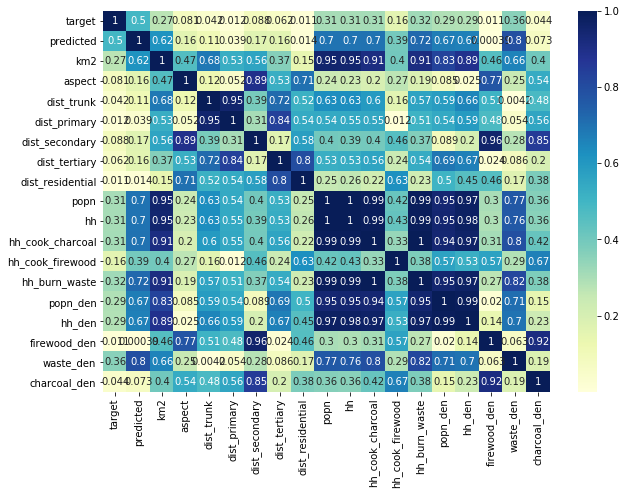

,ID,location,target,km2,popn,hh,hh_burn_waste,predicted,popn_den,hh_den,waste_den
0,ID_train_100,A,53.850238,1.9,4763,809,142,62.322230,2.506842,0.425789,0.175525
1,ID_train_10003,A,205.215333,1.9,4763,809,142,61.658126,2.506842,0.425789,0.175525
2,ID_train_10017,A,81.085122,1.9,4763,809,142,67.484192,2.506842,0.425789,0.175525
3,ID_train_10028,A,21.045814,1.9,4763,809,142,46.413807,2.506842,0.425789,0.175525
4,ID_train_10041,A,48.328837,1.9,4763,809,142,66.391580,2.506842,0.425789,0.175525


In [86]:
L2dataset=pd.merge(master_L2.copy(),locdata.copy(),how='inner',on='location')
plt.figure(figsize=(10,7))
sns.heatmap(L2dataset.corr().abs(), cmap="YlGnBu", annot=True)
plt.show()
L2dataset_mod=L2dataset[['ID','location', 'target','km2','popn','hh','hh_burn_waste', 'predicted','popn_den', 
                         'hh_den', 'waste_den']].copy()
L2dataset_mod.head()

## Modelling

In [87]:
from sklearn.model_selection import train_test_split
X = L2dataset_mod.copy()
X.drop(['ID','target','location'],axis=1,inplace=True)
y = L2dataset_mod['target'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
predicted_l1=list(X_test['predicted'])

In [30]:
from catboost import CatBoostRegressor
catb=CatBoostRegressor(iterations=1500, depth=8, learning_rate=0.1, loss_function='RMSE')

categorical_features_indices= np.array([0])

catb.fit(X_train, y_train,cat_features=categorical_features_indices,logging_level='Silent')
predictions = catb.predict(X_test)
errA=sqrt(mean_squared_error(y_test, predictions))
print("Error:",sqrt(mean_squared_error(y_test, predictions)))

Error: 44.66845152840545


In [88]:
from sklearn.linear_model import Lasso
lm = Lasso(alpha=0.0001)

lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
errA=sqrt(mean_squared_error(y_test, predictions))
print("Error - A:",sqrt(mean_squared_error(y_test, predictions)))

Error - A: 36.19215605717167


C:\Users\soumi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


# Application of models on test set

In [89]:
Test_Data_A=test.loc[test['location']=='A'].iloc[:,2:].copy()
Test_Data_A_id=test.loc[test['location']=='A'].iloc[:,[0,1]].copy()
Test_Data_B=test.loc[test['location']=='B'].iloc[:,2:].copy()
Test_Data_B_id=test.loc[test['location']=='B'].iloc[:,[0,1]].copy()
Test_Data_C=test.loc[test['location']=='C'].iloc[:,2:].copy()
Test_Data_C_id=test.loc[test['location']=='C'].iloc[:,[0,1]].copy()
Test_Data_D=test.loc[test['location']=='D'].iloc[:,2:].copy()
Test_Data_D_id=test.loc[test['location']=='D'].iloc[:,[0,1]].copy()
Test_Data_E=test.loc[test['location']=='E'].iloc[:,2:].copy()
Test_Data_E_id=test.loc[test['location']=='E'].iloc[:,[0,1]].copy()

In [90]:
# option 1 -Apply rfC 
predictionsA = rfc_A.predict(Test_Data_A)
predictionsB = rfc_B.predict(Test_Data_B)
predictionsC = rfc_C.predict(Test_Data_C)
predictionsD = rfc_D.predict(Test_Data_D)
predictionsE = rfc_E.predict(Test_Data_E)

In [91]:
Test_sub_A=pd.DataFrame(Test_Data_A_id.copy())
Test_sub_A['predicted']=list(predictionsA)

Test_sub_B=pd.DataFrame(Test_Data_B_id.copy())
Test_sub_B['predicted']=list(predictionsB)

Test_sub_C=pd.DataFrame(Test_Data_C_id.copy())
Test_sub_C['predicted']=list(predictionsC)

Test_sub_D=pd.DataFrame(Test_Data_D_id.copy())
Test_sub_D['predicted']=list(predictionsD)

Test_sub_E=pd.DataFrame(Test_Data_E_id.copy())
Test_sub_E['predicted']=list(predictionsE)

master_Test=pd.concat([Test_sub_A,Test_sub_B,Test_sub_C,Test_sub_D,Test_sub_E],axis=0)
master_Test

,ID,location,predicted
11,ID_test_1007,A,57.305825
15,ID_test_1010,A,60.533523
16,ID_test_1011,A,46.808038
25,ID_test_102,A,65.706730
27,ID_test_1021,A,70.493224
...,...,...,...
4951,ID_test_923,E,40.478214
4967,ID_test_938,E,52.825628
5021,ID_test_987,E,49.688634
5029,ID_test_994,E,37.738405


In [92]:
master_test1=pd.merge(master_Test.copy(),locdata.copy(),how='inner',on='location')
master_test1=master_test1[['ID','location','km2','popn','hh','hh_burn_waste', 'predicted','popn_den', 
                         'hh_den', 'waste_den']].copy()
master_test1.head()

,ID,location,km2,popn,hh,hh_burn_waste,predicted,popn_den,hh_den,waste_den
0,ID_test_1007,A,1.9,4763,809,142,57.305825,2.506842,0.425789,0.175525
1,ID_test_1010,A,1.9,4763,809,142,60.533523,2.506842,0.425789,0.175525
2,ID_test_1011,A,1.9,4763,809,142,46.808038,2.506842,0.425789,0.175525
3,ID_test_102,A,1.9,4763,809,142,65.706730,2.506842,0.425789,0.175525
4,ID_test_1021,A,1.9,4763,809,142,70.493224,2.506842,0.425789,0.175525


In [93]:
master_test_features=master_test1.copy()
master_test_features=master_test_features.drop(['ID','location'],axis=1)
master_test_ID=master_test1['ID'].copy()
predictions = lm.predict(master_test_features)
master_sub=pd.DataFrame(master_test_ID)
master_sub['target']=list(predictions)
master_sub=master_sub.sort_values(by='ID',ascending=True)
master_sub.set_index(['ID'],inplace=True)
master_sub

,target
ID,
ID_test_0,93.615034
ID_test_1,131.530399
ID_test_10,46.309273
ID_test_100,106.907705
ID_test_1000,90.249782
...,...
ID_test_995,100.245052
ID_test_996,51.836370
ID_test_997,58.995058


In [94]:
master_sub.to_csv("submission28-stacked-tuned RF+lasso.csv")